In [64]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
import torch


In [65]:
with open("inference_data", "rb") as fp:
    data_list = pickle.load(fp)

df = pd.DataFrame(data_list)
df.columns = ["name", "pop", "inner", "answer"]

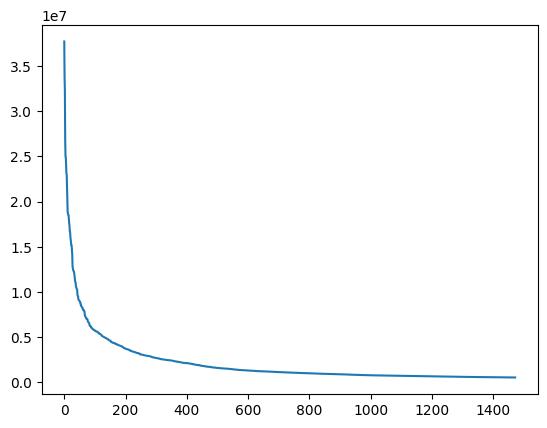

In [66]:
plt.plot(df["pop"])
plt.show()

In [67]:
print("Amount of cities bigger then 1 mio:", len(df[df["pop"]>1e6]))
print("Amount of cities smaller then 1 mio:",len(df[df["pop"]<1e6]))

Amount of cities bigger then 1 mio: 771
Amount of cities smaller then 1 mio: 699


In [68]:
binary_answers = df["answer"].map(lambda x: 0 if x == "No" else 1)

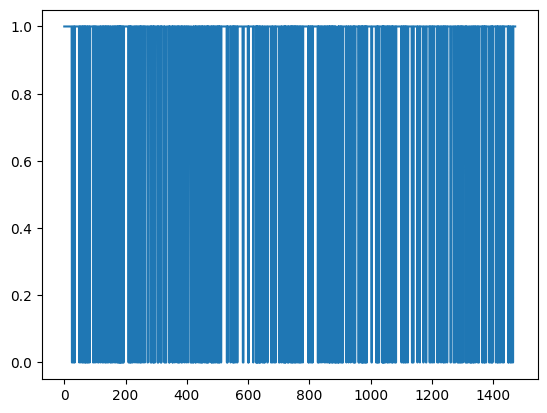

In [69]:
plt.plot(binary_answers)
plt.show()

All responses are well respected:

In [70]:
for i, answer in enumerate(df["answer"]):
    if not answer in ["No", "Yes"]:
        print(answer)

When is the model making mistakes:
- Many non western cities are ignored from the big cities
- The city wrongly considered as large are few and mostly still quite big

In [71]:
error_count = 0
for i, answer in enumerate(df["answer"]):
    if answer == "No" and int(df["pop"].iloc[i]) > 1e6:
        # print(df["name"].iloc[i], df["pop"].iloc[i])
        error_count += 1
    if answer == "Yes" and int(df["pop"].iloc[i]) < 1e6:
        # print(df["name"].iloc[i], df["pop"].iloc[i])
        error_count += 1
print("error amount:", error_count)

error amount: 727


In [78]:
print("amount of yes:", len(df[df["answer"]=="Yes"]))

amount of yes: 1122


In [72]:
def colorization(df, i):
    if df.iloc[i]["pop"] > 1e6:
        return "blue"
    else :#df.iloc[i]["answer"] == "Yes":
        return "red"
    
def binary_colorization(b):
    if b:
        return "blue"
    else :
        return "red"

torch.Size([1473, 4096])
(1473, 2)


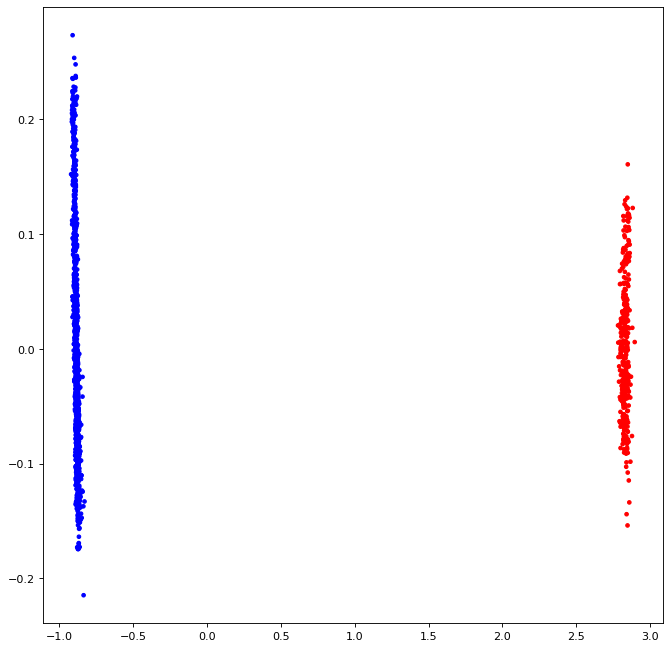

In [74]:
inner_states = df["inner"].values
inner_states = torch.stack(list(inner_states))
print(inner_states.shape)

colors = [binary_colorization(df.iloc[i]["answer"] == "Yes") for i in range(len(df))]

X = inner_states.type(torch.float64).cpu().numpy()

pca = PCA(n_components=2)
x = pca.fit_transform(X)

plt.figure(figsize=(10, 10), dpi=80)
print(x.shape)
plt.scatter(x[:, 0], x[:, 1], c=colors, s=10)
plt.show()

In [75]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


label = [1 if df.iloc[i]["pop"] > 1e6 else 0 for i in range(len(df))]

X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=.2)
# create model instance
bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
# fit model
bst.fit(X_train, y_train)
# make predictions
probas = bst.predict_proba(X_test)
preds = bst.predict(X_test)

In [76]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.61      0.48      0.53       138
           1       0.61      0.73      0.66       157

    accuracy                           0.61       295
   macro avg       0.61      0.60      0.60       295
weighted avg       0.61      0.61      0.60       295



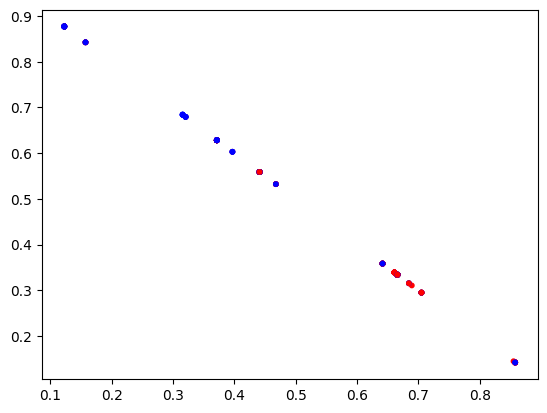

In [77]:
colors = [binary_colorization(y_test[i]) for i in range(len(probas))]
plt.scatter(probas[:, 0], probas[:, 1], c=colors, s=10)
plt.show()